# Master M3IR
# TP 1, exercice 3: Classification simple d'images

Cet exercice est à réaliser avec l'environnement Jupyter d'Anaconda https://www.anaconda.com/

**Objectif:** Analyse en composantes principales, Classification par régression logistique  

In [1]:
# Initialisations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sklearn

In [2]:
from sklearn.decomposition import PCA

## Données

On va utiliser des images en niveau de gris de visages, 

> Grayscale faces 8 bit `[0-255]`, a few images of several different people.
> 400 total images, 64x64 size.
> From the Olivetti database at ATT.

Fichier à télécharger: [olivettifaces.mat](http://www-l2ti.univ-paris13.fr/~viennet/ens/AFDV/data/olivettifaces.mat) (4,1Mo).

Le format est un peu spécial, il s'agit d'une matrice matlab. On va le lire comme suit:

In [3]:
D = scipy.io.loadmat('./olivettifaces.mat') # modifier chemin si nécessaire
# La matrice est transposée (lignes/colonnes):
X = D['faces'].transpose()
print(X.shape)

(400, 4096)


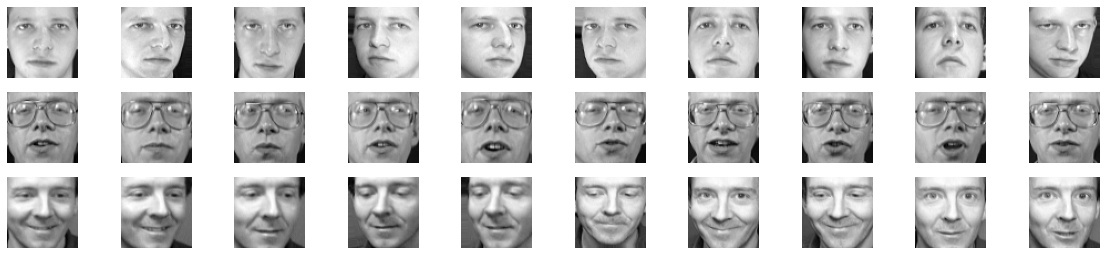

In [4]:
# Affichage de quelques exemples:
plt.figure(figsize=(20,6))
N = 30 # nombre d'exemples à afficher
MaxNbPerLine = 10 

nrows = N // MaxNbPerLine + 1 
ncols = min(N, MaxNbPerLine)
index = 1 # indice dans la figure

for idx, image in enumerate(X[:N]):
    plt.subplot(nrows, ncols, index)
    plt.axis('off')    
    plt.imshow(image.reshape((64,64)).transpose(), cmap=plt.cm.gray)
    index += 1

On voit qu'on a dix images de chaque personne, dans l'ordre. Chaque image est de taille 64x64 = 4096 pixels.


## Image moyenne
Convertir les images en float, calculer et afficher l'image moyenne.

Type of image:  float64
Type of image:  float64
Type of image:  float64
Type of image:  float64


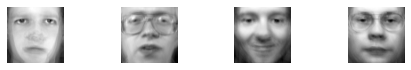

In [5]:
# Réponse

# Affichage de quelques exemples:
plt.figure(figsize=(20,6))
N = 40 # nombre d'exemples à afficher
MaxNbPerLine = 10 

nrows = N // MaxNbPerLine + 1 
ncols = min(N, MaxNbPerLine)
index = 1 # indice dans la figure

## create a list to store list images of a person
list_img_per = []
## a variable to count the images of a person
count = 0

for image in X[:N]:
    list_img_per.append(image)
    count += 1
    if count % MaxNbPerLine == 0:
        array_img_per = np.array(list_img_per, dtype = float)
        print('Type of image: ',array_img_per.dtype)
        array_img_per_mean = np.mean(array_img_per, axis = 0)
        list_img_per = [] 
        plt.subplot(nrows, ncols, index)
        plt.axis('off')
        plt.imshow(array_img_per_mean.reshape((64,64)).transpose(), cmap=plt.cm.gray)
        index += 1

## Analyse en composantes principales
Calculer une ACP pour projeter les images en deux dimensions et afficher les images dans le plan.

In [6]:
array_img_per.shape

(10, 4096)

In [7]:
X.shape

(400, 4096)

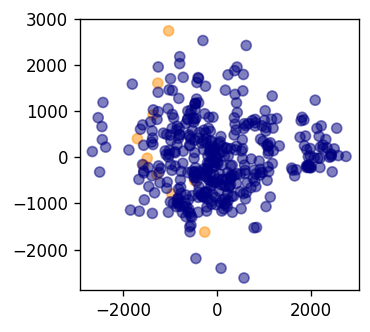

In [8]:
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(X)

color = ['darkorange']*10 + ['navy']*390
plt.figure(figsize=(3, 3), dpi=120)
x = [item[0] for item in feature_pca.tolist()]
y = [item[1] for item in feature_pca.tolist()]
plt.scatter(x, y, color= color, alpha=0.5)
plt.show()

## Classification

Estimer un modèle de classification par régression logistique. Le modèle sera estimé (appris) sur 7 visages par personne, et testé sur les 3 images restantes.

On pourra s'inspirer de l'[exemple de la documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)

Quelle est la personne sur laquelle le modèle commet le plus d'erreurs ?

### Adopting scikit-learn library

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from IPython import display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


def logreg_classifier(dataset, vis_res = False, use_pca = False, ncomp = None):
    """
    pipeline logistic regression classification using sklearn
    need to investigate the number of components for the best performance
    
    params:
        dataset: flatten images of 40 persons
        vis_res: visualize result in validation set
        use_pca: adopt PCA transform
        ncomp: investigate a list number of component
        
    return:
        acc: accuracy
    """
    if use_pca:
        pca = PCA(n_components=ncomp)
        feature = pca.fit_transform(dataset)
    else:
        feature = dataset
    
    n_per = 40
    df_ = pd.DataFrame([])
    df_['data'] = list(feature[:n_per*10])
    per_id = sorted(list(range(n_per))*10)
    df_['label'] = per_id
    
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])

    for per_id in range(40):
        df_per = df_[df_['label']==per_id]
        df_per = df_per.sample(frac = 1).reset_index()
        df_per_train, df_per_valid = df_per[:7], df_per[7:]
        df_train = pd.concat([df_train, df_per_train], axis = 0)
        df_valid = pd.concat([df_valid, df_per_valid], axis = 0)
    
    logreg = LogisticRegression(max_iter=2500)
    logreg.fit(np.array(list(df_train['data'])), df_train['label'])
    
    y_pred = logreg.predict(np.array(list(df_valid['data'])))
    valid_acc = metrics.accuracy_score(df_valid.label, y_pred)
    
    y_hat = logreg.predict(np.array(list(df_train['data'])))
    train_acc = metrics.accuracy_score(df_train.label, y_hat)
    
    df_valid['pred'] = y_pred
    if vis_res:
        display.display(df_valid.head(10))     
        
        cf_matrix = confusion_matrix(df_valid.label, y_pred)
        plt.figure(figsize = (10,10))
        sns.heatmap(cf_matrix, annot=True, cmap='Blues')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        
        df_valid_diff = df_valid.iloc[np.where(np.equal(df_valid.label, y_pred)==False)]
        dict_diff = dict(df_valid_diff['label'].value_counts())
        for kv in list(dict_diff.items()):
            print('PersonID: {0} error {1}/3 faces'.format(kv[0], kv[1]))
        
    return train_acc, valid_acc

#### Training without decrease dimension

,index,data,label,pred
7,4,"[121, 116, 119, 119, 120, 127, 141, 141, 141, ...",0,0
8,2,"[77, 75, 65, 53, 49, 50, 47, 43, 48, 64, 90, 1...",0,0
9,0,"[75, 83, 83, 74, 81, 76, 75, 64, 60, 64, 69, 7...",0,0
7,17,"[142, 152, 148, 148, 151, 167, 169, 155, 137, ...",1,1
8,12,"[159, 164, 169, 170, 167, 166, 166, 166, 166, ...",1,1
9,13,"[152, 156, 160, 165, 170, 169, 169, 168, 167, ...",1,1
7,25,"[46, 47, 42, 42, 37, 38, 38, 42, 51, 57, 55, 5...",2,36
8,23,"[48, 43, 42, 40, 38, 37, 33, 40, 45, 52, 57, 6...",2,2
9,27,"[42, 37, 35, 33, 35, 37, 41, 45, 47, 48, 51, 4...",2,2
7,36,"[45, 45, 63, 87, 106, 118, 128, 134, 138, 141,...",3,14


PersonID: 2 error 1/3 faces
PersonID: 3 error 1/3 faces
PersonID: 9 error 1/3 faces
PersonID: 21 error 1/3 faces
PersonID: 39 error 1/3 faces
Training accuracy classification: 100.000%
Validation accuracy classification: 95.833%


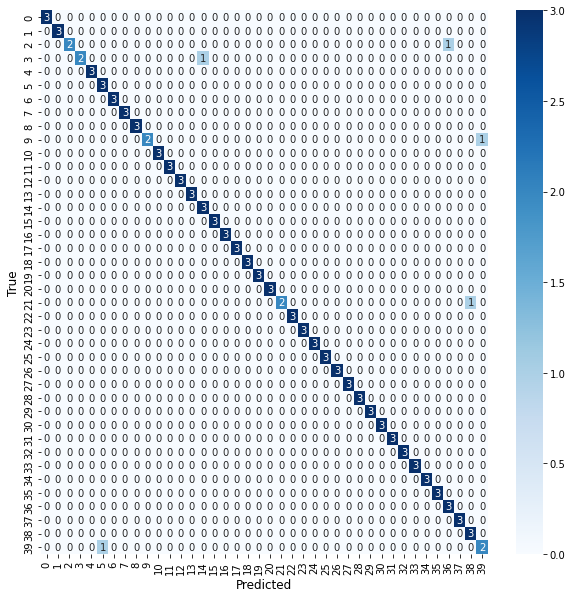

In [10]:
train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = True)
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')

#### Investigate the best number of components to decrease dimension

In [11]:
list_ncomp = list(range(2,100,2))
valid_accs = []
for ncomp in tqdm(list_ncomp):
    train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = False, use_pca = True, ncomp = ncomp)
    valid_accs.append(valid_acc)

  2%|█▎                                                             | 1/49 [00:01<01:01,  1.28s/it]C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  4%|██▌                                                            | 2/49 [00:02<01:06,  1.41s/it]C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

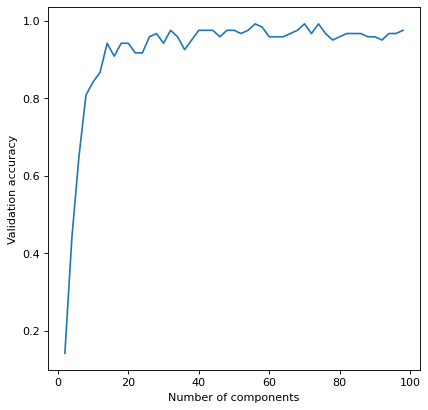

In [12]:
plt.figure(figsize=(6, 6), dpi=80)
plt.plot(list_ncomp,valid_accs)
plt.xlabel('Number of components')
plt.ylabel('Validation accuracy')
plt.show()

,index,data,label,pred
7,5,"[-1259.3773906429087, 1608.6739837608911, -150...",0,4
8,9,"[-474.69296601230184, -506.83150789085596, 136...",0,0
9,3,"[-1029.365510045212, 2741.314553030355, 22.231...",0,12
7,12,"[-126.83738432430533, -623.0865248062828, -678...",1,1
8,16,"[230.31700539936938, -328.9158197066101, -359....",1,1
9,19,"[-63.61263333062263, -380.3460027135304, -556....",1,1
7,21,"[626.2723729221696, -763.0138462257656, 256.78...",2,2
8,20,"[642.6234093737593, -553.4837785852756, 680.41...",2,2
9,26,"[-621.7301879941583, 837.6331034537506, 914.70...",2,2
7,38,"[291.78355740231507, -403.9562872597502, -592....",3,3


PersonID: 0 error 2/3 faces
PersonID: 25 error 2/3 faces
PersonID: 4 error 1/3 faces
PersonID: 7 error 1/3 faces
PersonID: 12 error 1/3 faces
PersonID: 15 error 1/3 faces
PersonID: 21 error 1/3 faces
The best number of components is: 56
Training accuracy classification: 100.000%
Validation accuracy classification: 92.500%


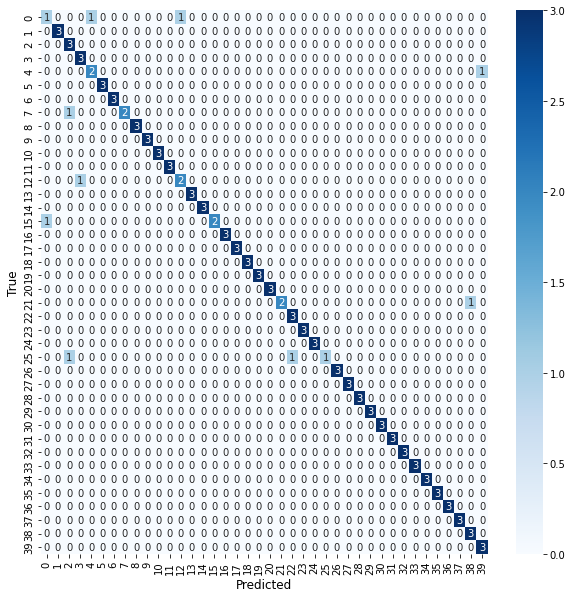

In [13]:
best_ncomp = list_ncomp[valid_accs.index(max(valid_accs))]
train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = True, use_pca = True, ncomp = best_ncomp)
print(f'The best number of components is: {best_ncomp}')
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')

### From scratch using Pytorch

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn
from fastprogress import progress_bar
from PIL import Image
from sklearn import metrics
from torch.nn import functional as F
from sklearn import metrics
from IPython import display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Define hyper-parametter configuration

In [62]:
config = {}
config['batch_size'] = 16

config['output_dim'] = 40
config['lr'] = 1e-2
config['early_stop'] = 1e-5
config['epochs'] = 3000
config['period'] = 100

In [49]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### Build dataset class

In [17]:
class Person(Dataset):
    def __init__(self, dataframe, tfs, use_pca = False):
        self.dataframe = dataframe
        self.tfs = tfs
        self.use_pca = use_pca
    def __getitem__(self, idx):
        arr_img = self.dataframe['data'].iloc[idx]
        label = self.dataframe['label'].iloc[idx]     
        
        if self.use_pca:
            img = Image.fromarray(arr_img)
            img = transforms.ToTensor()(img)
        else:
            arr_img_reshape = arr_img.reshape((64,64)).transpose()
            img = Image.fromarray(arr_img_reshape)
            img = self.tfs(img)
            img = torch.flatten(img)
        
        img = torch.tensor(img, dtype = torch.float)
        img = torch.squeeze(img)
        label = torch.tensor(label, dtype = torch.long)
        return img, label
    def __len__(self):
        return len(self.dataframe)

In [18]:
torch.manual_seed(17)
def get_transform(train):
    tfs = []
    if train:        
        tfs.append(transforms.RandomHorizontalFlip(0.5))
        tfs.append(transforms.RandomRotation(degrees=10, fill=(0,)))
    tfs.append(transforms.ToTensor())
    return transforms.Compose(tfs)

In [19]:
def show_batch(dataloader):
    plt.figure(figsize=(20,6))
    nrows = 4
    ncols = 4
    index = 1
    for idx, (imgs, labels) in enumerate(dataloader):
        for i, img in enumerate(imgs):
            if index == 9:
                break
            plt.subplot(nrows, ncols, index)
            plt.axis('off')  
            img = np.array(img)
            img = img.reshape((64,64))
            plt.imshow(img, cmap=plt.cm.gray)
            index += 1            
    plt.show()

#### Build Logistic Regression Classification model

In [50]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=True)
#         self.dropout = torch.nn.Dropout(p=0.15, inplace=False)
#         self.bn1 = nn.BatchNorm1d(num_features=output_dim)

    def forward(self, x):
        outputs = self.linear(x)
#         return self.bn1(outputs)
        return outputs

#### Utils function

In [51]:
def train_one(model, dataloader, criterion, optimizer, device):
    losses = 0
    accs = 0
    count = 0
    model.train()
    for x, y in dataloader:
        yhat = model(x.to(device))
        yhat = yhat.cpu()
        
        loss = criterion(yhat, y)
        losses += loss.item()
        
        count += y.size(0)
        _, pred = torch.max(yhat.data, 1)
        accs += (pred == y).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    loss_mean = losses/len(dataloader)
    acc_mean = accs/count
    
    return loss_mean, acc_mean

def eval_one(model, dataloader, criterion, device):
    losses = 0
    accs = 0
    count = 0
    with torch.no_grad():
        for x, y in dataloader:
            yhat = model(x.to(device))
            yhat = yhat.cpu()

            loss = criterion(yhat, y)
            losses += loss.item()

            count += y.size(0)
            _, pred = torch.max(yhat.data, 1)
            accs += (pred == y).sum()


        loss_mean = losses/len(dataloader)
        acc_mean = accs/count
    
    return loss_mean, acc_mean

def feedward(model, dataloader, device):
    preds = []
    with torch.no_grad():
        for x, y in dataloader:
            yhat = model(x.to(device))
            yhat = yhat.cpu()
            _, pred = torch.max(yhat.data, 1)
            pred = list(pred)
            pred = [x.item() for x in pred]
            preds += list(pred)
    return preds

def save_model(model, epoch):
    """
    checkpoint = {
            'model': model structure,
            'model_state_dict': model parametter,
        }
    """
    
    checkpoint = {
            'model': model,
            'epoch': epoch,
            'model_state_dict':model.state_dict()
            }    
    torch.save(checkpoint, './logreg_face_classifier.pth')
#     print('Saved checkpoint')
    
def get_model(checkpoint_dir = './logreg_face_classifier.pth'):
    checkpoint = torch.load(checkpoint_dir)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [57]:
def logreg_classifier(dataset, config, device, vis_res = False, use_pca = False, ncomp = None):
    """
    pipeline logistic regression classification using sklearn
    need to investigate the number of components for the best performance
    
    params:
        dataset: flatten images of 40 persons
        vis_res: visualize result in validation set
        use_pca: adopt PCA transform
        ncomp: investigate a list number of component
        
    return:
        acc: accuracy
    """
    if use_pca:
        pca = PCA(n_components=ncomp)
        feature = pca.fit_transform(sklearn.preprocessing.normalize(dataset))
        config['input_dim'] = ncomp
    else:
        config['input_dim'] = 4096
        feature = dataset
    
    n_per = 40
    df_ = pd.DataFrame([])
    df_['data'] = list(feature[:n_per*10])
    per_id = sorted(list(range(n_per))*10)
    df_['label'] = per_id
    
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])

    for per_id in range(40):
        df_per = df_[df_['label']==per_id]
        df_per = df_per.sample(frac = 1).reset_index()
        df_per_train, df_per_valid = df_per[:7], df_per[7:]
        df_train = pd.concat([df_train, df_per_train], axis = 0)
        df_valid = pd.concat([df_valid, df_per_valid], axis = 0)
    
    
    model = LogisticRegression(input_dim = config['input_dim'], output_dim = config['output_dim'])
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    
    train_ds = Person(df_train, get_transform(True), use_pca)
    train_dl = DataLoader(train_ds, batch_size=config['batch_size'], shuffle = True)

    valid_ds = Person(df_valid, get_transform(False), use_pca)
    valid_dl = DataLoader(valid_ds, batch_size=config['batch_size'])
    
    if vis_res and not use_pca:
        print('Visualize augmented transforms')
        show_batch(train_dl)
    
    best_acc_valid = 0
    best_acc_train = 0
    
#     old_train_loss = 0
    
    for e_idx, epoch in enumerate(range(config['epochs'])):
        train_loss, train_acc = train_one(model, train_dl, criterion, optimizer, device)
#         diff_train_loss = old_train_loss - train_loss
#         old_train_loss = train_loss
#         if diff_train_loss < config['early_stop'] and diff_train_loss > 0:
#             if vis_res:
#                 print(diff_train_loss, old_train_loss, train_loss)
#                 print('Early Stopping')
#             break
        if best_acc_train < train_acc:
            best_acc_train = train_acc
        if (e_idx % config['period'])==0:
            
            valid_loss, valid_acc = eval_one(model, valid_dl, criterion, device)
            
            if best_acc_valid < valid_acc:
                best_acc_valid = valid_acc
                save_model(model, epoch)
            if vis_res:
                print('Epoch: {0}'.format(epoch))
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}')
                print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc:.3f}')
    
    model = get_model()
    y_pred = feedward(model, valid_dl, device)    
        
    df_valid['pred'] = y_pred
    if vis_res:
        display.display(df_valid.head(10))     
        cf_matrix = confusion_matrix(df_valid.label, y_pred)
        plt.figure(figsize = (10,10))
        sns.heatmap(cf_matrix, annot=True, cmap='Blues')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        
        df_valid_diff = df_valid.iloc[np.where(np.equal(df_valid.label, y_pred)==False)]
        dict_diff = dict(df_valid_diff['label'].value_counts())
        for kv in list(dict_diff.items()):
            print('PersonID: {0} error {1}/3 faces'.format(kv[0], kv[1]))
        
    return best_acc_train, best_acc_valid

#### Training without decrease dimension

Visualize augmented transforms


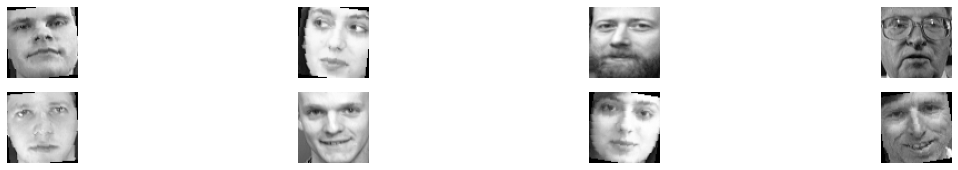

Epoch: 0
	Train Loss: 3.887 | Train Acc: 0.021
	Valid Loss: 3.786 | Valid Acc: 0.050
Epoch: 100
	Train Loss: 0.968 | Train Acc: 0.946
	Valid Loss: 1.089 | Valid Acc: 0.825
Epoch: 200
	Train Loss: 0.480 | Train Acc: 0.989
	Valid Loss: 0.790 | Valid Acc: 0.783
Epoch: 300
	Train Loss: 0.289 | Train Acc: 0.986
	Valid Loss: 0.513 | Valid Acc: 0.908
Epoch: 400
	Train Loss: 0.214 | Train Acc: 1.000
	Valid Loss: 0.476 | Valid Acc: 0.883
Epoch: 500
	Train Loss: 0.158 | Train Acc: 1.000
	Valid Loss: 0.408 | Valid Acc: 0.933
Epoch: 600
	Train Loss: 0.140 | Train Acc: 1.000
	Valid Loss: 0.382 | Valid Acc: 0.908
Epoch: 700
	Train Loss: 0.113 | Train Acc: 1.000
	Valid Loss: 0.348 | Valid Acc: 0.917
Epoch: 800
	Train Loss: 0.095 | Train Acc: 1.000
	Valid Loss: 0.342 | Valid Acc: 0.917
Epoch: 900
	Train Loss: 0.080 | Train Acc: 1.000
	Valid Loss: 0.323 | Valid Acc: 0.925
Epoch: 1000
	Train Loss: 0.080 | Train Acc: 1.000
	Valid Loss: 0.320 | Valid Acc: 0.925
Epoch: 1100
	Train Loss: 0.073 | Train Acc: 

,index,data,label,pred
7,2,"[77, 75, 65, 53, 49, 50, 47, 43, 48, 64, 90, 1...",0,0
8,9,"[92, 94, 89, 93, 108, 121, 125, 125, 125, 128,...",0,0
9,8,"[59, 53, 60, 59, 55, 53, 53, 53, 50, 50, 51, 5...",0,0
7,19,"[137, 143, 147, 149, 150, 154, 163, 162, 147, ...",1,1
8,17,"[142, 152, 148, 148, 151, 167, 169, 155, 137, ...",1,1
9,13,"[152, 156, 160, 165, 170, 169, 169, 168, 167, ...",1,1
7,28,"[126, 118, 117, 114, 124, 127, 124, 123, 127, ...",2,2
8,29,"[131, 127, 126, 132, 136, 136, 136, 134, 136, ...",2,2
9,20,"[140, 134, 129, 134, 136, 139, 140, 139, 143, ...",2,2
7,38,"[175, 175, 171, 170, 171, 172, 168, 159, 145, ...",3,3


PersonID: 4 error 1/3 faces
PersonID: 9 error 1/3 faces
PersonID: 12 error 1/3 faces
PersonID: 16 error 1/3 faces
PersonID: 17 error 1/3 faces
PersonID: 21 error 1/3 faces
PersonID: 31 error 1/3 faces
PersonID: 39 error 1/3 faces
Training accuracy classification: 100.000%
Validation accuracy classification: 93.333%


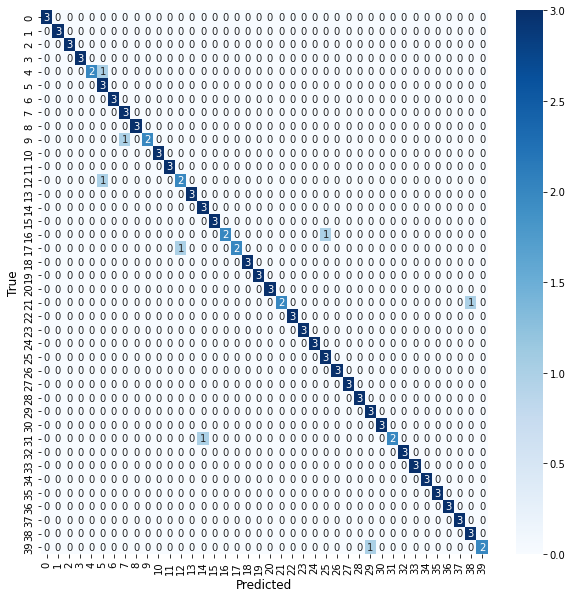

In [53]:
train_acc, valid_acc = logreg_classifier(dataset=X, config=config, device=device, vis_res = True)
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')

#### Investigate the best number of components to decrease dimension

In [63]:
list_ncomp = list(range(2,100,2))
valid_accs = []
for ncomp in tqdm(list_ncomp):
    train_acc, valid_acc = logreg_classifier(dataset = X, config=config, device=device, vis_res = False, use_pca = True, ncomp = ncomp)
    valid_accs.append(valid_acc.item())

100%|███████████████████████████████████████████████████████████| 49/49 [2:12:31<00:00, 162.28s/it]


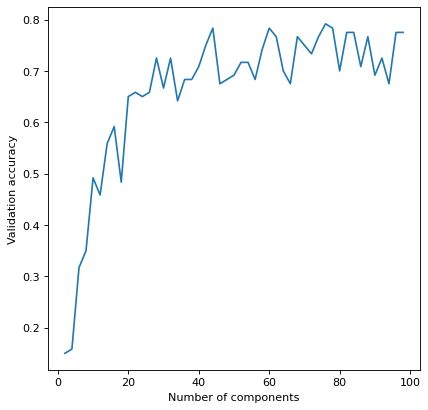

In [64]:
plt.figure(figsize=(6, 6), dpi=80)
plt.plot(list_ncomp,valid_accs)
plt.xlabel('Number of components')
plt.ylabel('Validation accuracy')
plt.show()

Epoch: 0
	Train Loss: 3.691 | Train Acc: 0.018
	Valid Loss: 3.687 | Valid Acc: 0.025
Epoch: 100
	Train Loss: 3.679 | Train Acc: 0.054
	Valid Loss: 3.678 | Valid Acc: 0.067
Epoch: 200
	Train Loss: 3.667 | Train Acc: 0.157
	Valid Loss: 3.669 | Valid Acc: 0.108
Epoch: 300
	Train Loss: 3.657 | Train Acc: 0.321
	Valid Loss: 3.660 | Valid Acc: 0.267
Epoch: 400
	Train Loss: 3.646 | Train Acc: 0.518
	Valid Loss: 3.651 | Valid Acc: 0.375
Epoch: 500
	Train Loss: 3.635 | Train Acc: 0.593
	Valid Loss: 3.642 | Valid Acc: 0.467
Epoch: 600
	Train Loss: 3.625 | Train Acc: 0.621
	Valid Loss: 3.633 | Valid Acc: 0.525
Epoch: 700
	Train Loss: 3.613 | Train Acc: 0.671
	Valid Loss: 3.624 | Valid Acc: 0.558
Epoch: 800
	Train Loss: 3.603 | Train Acc: 0.725
	Valid Loss: 3.615 | Valid Acc: 0.592
Epoch: 900
	Train Loss: 3.593 | Train Acc: 0.736
	Valid Loss: 3.606 | Valid Acc: 0.600
Epoch: 1000
	Train Loss: 3.582 | Train Acc: 0.739
	Valid Loss: 3.598 | Valid Acc: 0.625
Epoch: 1100
	Train Loss: 3.571 | Train Acc: 

Epoch: 9400
	Train Loss: 2.809 | Train Acc: 0.882
	Valid Loss: 2.941 | Valid Acc: 0.792
Epoch: 9500
	Train Loss: 2.797 | Train Acc: 0.882
	Valid Loss: 2.934 | Valid Acc: 0.792
Epoch: 9600
	Train Loss: 2.789 | Train Acc: 0.886
	Valid Loss: 2.927 | Valid Acc: 0.792
Epoch: 9700
	Train Loss: 2.776 | Train Acc: 0.882
	Valid Loss: 2.920 | Valid Acc: 0.783
Epoch: 9800
	Train Loss: 2.768 | Train Acc: 0.889
	Valid Loss: 2.914 | Valid Acc: 0.792
Epoch: 9900
	Train Loss: 2.768 | Train Acc: 0.889
	Valid Loss: 2.907 | Valid Acc: 0.783


,index,data,label,pred
7,1,"[-0.1572578615204141, 0.028206964371755624, 0....",0,7
8,2,"[-0.0018775301870612281, -0.009391923628938505...",0,0
9,7,"[0.12971256725255645, 0.02692631642502702, -0....",0,0
7,11,"[-0.07289338823691917, -0.1217427899773679, -0...",1,1
8,13,"[-0.10008361174629393, -0.09275334658907838, -...",1,1
9,17,"[-0.06241276434098059, -0.06861334463430181, -...",1,1
7,29,"[-0.01902168953605505, 0.06508312235116942, -0...",2,9
8,25,"[0.03823760403250981, 0.10649756906315481, -0....",2,36
9,28,"[0.005432958191628577, 0.06753344664133004, -0...",2,9
7,35,"[0.17271286507304828, -0.010280702359100061, -...",3,20


PersonID: 2 error 3/3 faces
PersonID: 22 error 3/3 faces
PersonID: 5 error 2/3 faces
PersonID: 12 error 2/3 faces
PersonID: 16 error 2/3 faces
PersonID: 34 error 2/3 faces
PersonID: 39 error 2/3 faces
PersonID: 0 error 1/3 faces
PersonID: 3 error 1/3 faces
PersonID: 4 error 1/3 faces
PersonID: 17 error 1/3 faces
PersonID: 18 error 1/3 faces
PersonID: 20 error 1/3 faces
PersonID: 23 error 1/3 faces
PersonID: 25 error 1/3 faces
PersonID: 30 error 1/3 faces
The best number of components is: 76
Training accuracy classification: 89.286%
Validation accuracy classification: 79.167%


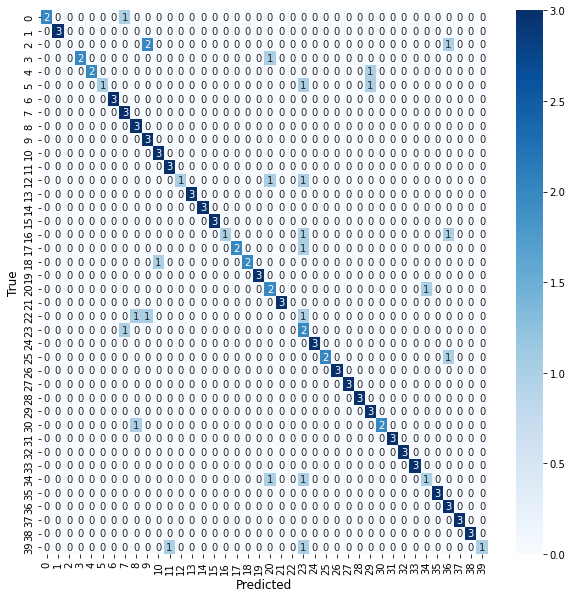

In [66]:
best_ncomp = list_ncomp[valid_accs.index(max(valid_accs))]
config['epochs'] = 10000
train_acc, valid_acc = logreg_classifier(dataset = X, config=config, device=device, vis_res = True, use_pca = True, ncomp = best_ncomp)

print(f'The best number of components is: {best_ncomp}')
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')